In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg 

import KF_Library as kf

In [2]:
# Model parameters from "Temporal parallelization of Bayesian smoothers" paper.
RunTime = 2000

dt = 0.1
sigma = 0.5
q = 1
F = np.array ([[1, 0, dt, 0 ],
               [0, 1, 0,  dt],
               [0, 0, 1,  0 ],
               [0, 0, 0,  1 ]])
Q = q * np.array ([[dt**3/3,    0,         dt**2/2,   0      ],
                   [0,          dt**3/3,   0,         dt**2/2],
                   [dt**2/2,    0,         dt,        0      ],
                   [0,          dt**2/2,   0,         dt     ]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.array([[sigma**2, 0],[0, sigma**2]])

m0 = np.array([[0 , 0, 1, -1]]).T
P0 = np.eye(4)

In [3]:
x = pd.read_excel('x.xlsx').values
y = pd.read_excel('y.xlsx').values

# Parallel kalman filter and RTS smoother


In [4]:
#filtering
a = kf.filteringInitializer(F, Q, H, R, y, m0, P0, RunTime)
kf_res = kf.parallelScanAlgorithm(a, RunTime, kf.filtering)

KF_m = []
KF_P = []
for k in range(len(kf_res)): 
    KF_m.append(kf_res[k]['b'])
    KF_P.append(kf_res[k]['C'])
    
#smoothing
b = kf.smoothingInitializer(F, Q, KF_m, KF_P, RunTime)
rts_res = kf.parallelScanAlgorithm(b, RunTime, kf.smoothing)

rts_m = np.zeros((len(rts_res[k]['g']),len(rts_res)))
rts_L = np.zeros((len(rts_res[k]['L']),len(rts_res[k]['L']),len(rts_res)))
for k in range(len(rts_res)):
    rts_m[:,RunTime-k-1,None] = rts_res[k]['g']
    rts_L[:,:,RunTime-k-1] = rts_res[k]['L']

    

## Parallel square root kalman filter and RTS smoother

In [5]:
W = scipy.linalg.cholesky(Q, lower=True)
V = scipy.linalg.cholesky(R, lower=True)
N_0 = scipy.linalg.cholesky(P0, lower=True)

In [6]:
# %time
#filtering
a_sqr = kf.SqrFilteringInitializer(F, W, H, V, y, m0, N_0, RunTime) 
sqr_kf_res = kf.parallelScanAlgorithm(a_sqr, RunTime, kf.SqrFiltering)

sqr_kf_m = []
sqr_kf_U = []
sqr_kf_eta = []
sqr_kf_Z = []
sqr_kf_A = []
for k in range(len(sqr_kf_res)): 
    sqr_kf_m.append(sqr_kf_res[k]['b'])
    sqr_kf_U.append(sqr_kf_res[k]['U'])
    sqr_kf_eta.append(sqr_kf_res[k]['eta'])
    sqr_kf_Z.append(sqr_kf_res[k]['Z'])
    sqr_kf_A.append(sqr_kf_res[k]['A'])

# smoothing    
b_sqr = kf.SqrSmoothingInitializer(F, W, sqr_kf_m, sqr_kf_U, RunTime)
sqr_rts_res = kf.parallelScanAlgorithm(b_sqr, RunTime, kf.SqrSmoothing)

sqr_rts_m = np.zeros((len(sqr_rts_res[k]['g']),len(sqr_rts_res)))
sqr_rts_D = np.zeros((len(sqr_rts_res[k]['D']),len(sqr_rts_res[k]['D']),len(sqr_rts_res)))
sqr_rts_E = np.zeros((len(sqr_rts_res[k]['E']),len(sqr_rts_res[k]['E']),len(sqr_rts_res)))
b_sqr_E = np.zeros((len(b_sqr[k]['E']),len(b_sqr[k]['E']),len(b_sqr)))
b_sqr_D = np.zeros((len(b_sqr[k]['D']),len(b_sqr[k]['D']),len(b_sqr)))
b_sqr_g = np.zeros((len(b_sqr[k]['g']),len(b_sqr)))
for k in range(len(sqr_rts_res)):
    sqr_rts_m[:,RunTime-k-1,None] = sqr_rts_res[k]['g']
    sqr_rts_D[:,:,RunTime-k-1] = sqr_rts_res[k]['D']
    sqr_rts_E[:,:,RunTime-k-1] = sqr_rts_res[k]['E']
    b_sqr_E[:,:,RunTime-k-1] = b_sqr[k]['E']
    b_sqr_D[:,:,RunTime-k-1] = b_sqr[k]['D']
    b_sqr_g[:,RunTime-k-1,None] = b_sqr[k]['g']

### Check the results

In [7]:
# problem
sqr_rts_D[:,:,2]

array([[ 0.18874787,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.18874787,  0.        ,  0.        ],
       [-0.20357208,  0.        ,  0.46801601,  0.        ],
       [ 0.        , -0.20357208,  0.        ,  0.46801601]])

In [27]:
sqr_rts_m[:,2]

array([ 0.94928359, -0.28400547,  0.93136415, -1.45964972])

In [43]:
a = {'E': b_sqr_E[:,:,1000], 'g': b_sqr_g[:,1000], 'D': b_sqr_D[:,:,1000]}
b = {'E': b_sqr_E[:,:,1500], 'g': b_sqr_g[:,1500], 'D': b_sqr_D[:,:,1500]}
kf.SqrSmoothing(a,b)

{'E': array([[ 0.90085439,  0.        , -0.13720395,  0.        ],
        [ 0.        ,  0.90085439,  0.        , -0.13720395],
        [ 0.86779015,  0.        ,  0.41287022,  0.        ],
        [ 0.        ,  0.86779015,  0.        ,  0.41287022]]),
 'g': array([-14.09704075, -65.41295714,  82.52869239, 720.50727087]),
 'D': array([[ 0.03927573,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.03927573,  0.        ,  0.        ],
        [-0.2396642 ,  0.        , -0.20602607,  0.        ],
        [ 0.        , -0.2396642 ,  0.        , -0.20602607]])}

In [9]:
DeviceArray([[ 0.03927573,  0.        ,  0.        ,  0.        ],
              [ 0.        ,  0.03927574,  0.        ,  0.        ],
              [-0.2396642 ,  0.        , -0.20602603,  0.        ],
              [ 0.        , -0.23966423,  0.        , -0.20602609]],            dtype=float32),

NameError: name 'DeviceArray' is not defined

In [32]:
b_sqr_E[:,:,1999]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [33]:
DeviceArray([[ 0.97196007,  0.        , -0.08326636,  0.        ],
             [ 0.        ,  0.97196007,  0.        , -0.08326636],
             [ 0.52664393,  0.        ,  0.67581224,  0.        ],
             [ 0.        ,  0.52664393,  0.        ,  0.67581224]],            dtype=float32)

NameError: name 'DeviceArray' is not defined

In [41]:
b_sqr_E[:,:,0]

array([[ 0.99800648,  0.        , -0.0955769 ,  0.        ],
       [ 0.        ,  0.99800648,  0.        , -0.0955769 ],
       [ 0.03155925,  0.        ,  0.91247948,  0.        ],
       [ 0.        ,  0.03155925,  0.        ,  0.91247948]])

In [ ]:
DeviceArray([[ 0.9980068 ,  0.        , -0.09557691,  0.        ],
             [ 0.        ,  0.9980068 ,  0.        , -0.09557691],
             [ 0.03155941,  0.        ,  0.9124794 ,  0.        ],
             [ 0.        ,  0.03155941,  0.        ,  0.9124794 ]],            dtype=float32)

In [40]:
b_sqr_D[:,:,0]

array([[-0.01765078,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.01765078,  0.        ,  0.        ],
       [ 0.25877933,  0.        ,  0.15632979,  0.        ],
       [ 0.        ,  0.25877933,  0.        ,  0.15632979]])

In [ ]:
DeviceArray([[-0.01765079,  0.        ,  0.        ,  0.        ],
             [ 0.        , -0.01765079,  0.        ,  0.        ],
             [ 0.25877932,  0.        ,  0.15632975,  0.        ],
             [ 0.        ,  0.25877932,  0.        ,  0.15632975]],            dtype=float32)

In [42]:
b_sqr_g[:,0]

array([-0.00483024,  0.0035621 ,  0.09302319, -0.07443089])

In [ ]:
DeviceArray([[-0.00483012],
             [ 0.00356224],
             [ 0.0930233 ],
             [-0.07443088]], dtype=float32)

In [26]:
sqr_rts_res[0]['D']

array([[-0.27353516,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.27353516,  0.        ,  0.        ],
       [-0.4838684 ,  0.        , -0.53026445,  0.        ],
       [ 0.        , -0.4838684 ,  0.        , -0.53026445]])

In [30]:
sqr_rts_D[:,:,2]

array([[ 0.18874787,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.18874787,  0.        ,  0.        ],
       [-0.20357208,  0.        ,  0.46801601,  0.        ],
       [ 0.        , -0.20357208,  0.        ,  0.46801601]])

In [29]:
sqr_rts_E[:,:,2]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [28]:
sqr_rts_m[:,1000]

array([-182.31927114, -514.59336529,    1.79084898,   -7.42892201])

In [69]:
(kf.SqrFiltering(a_sqr[5], a_sqr[7]))['A']

array([[ 0.98616298,  0.        ,  0.19756197,  0.        ],
       [ 0.        ,  0.98616298,  0.        ,  0.19756197],
       [-0.09880075,  0.        ,  0.98221086,  0.        ],
       [ 0.        , -0.09880075,  0.        ,  0.98221086]])

## Plot

In [7]:
kf_m = np.array(KF_m).reshape(-1,4).T
Sqr_kf_m = np.array(sqr_kf_m).reshape(-1,4).T

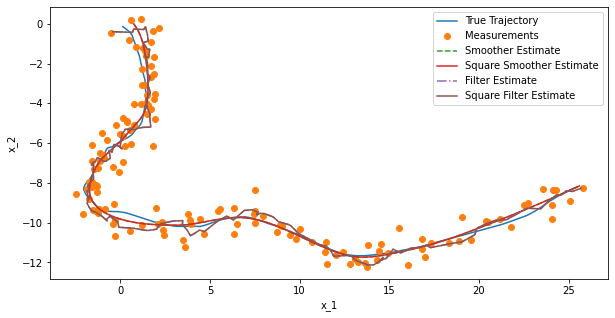

In [8]:
plt.figure(figsize=(10,5))
plt.plot(x[0,:140],x[1,:140],'-',
         y[0,:140],y[1,:140],'o',
         rts_m[0,:140],rts_m[1,:140],'--',
         sqr_rts_m[0,:140],sqr_rts_m[1,:140],
         kf_m[0,:140], kf_m[1,:140],'-.',
         Sqr_kf_m[0,:140], Sqr_kf_m[1,:140])
c=plt.legend(['True Trajectory','Measurements','Smoother Estimate', 'Square Smoother Estimate', 'Filter Estimate',  'Square Filter Estimate'])
a=plt.xlabel('x_1')
b=plt.ylabel('x_2')